In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
plt.rcParams['savefig.dpi'] = 500 
plt.rcParams['figure.dpi'] = 500
style.use('seaborn')
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

Using TensorFlow backend.


In [7]:
#read the data
std = pd.read_csv('time_std.csv')
e7_75 = pd.read_csv('time_e7_75.csv')
e7_72 = pd.read_csv('time_e7_72.csv')

std = std[['date','cost_mean','usage']]
e7_75 = e7_75[['date','cost_mean','usage']]
e7_72 = e7_72[['date','cost_mean','usage']]

std_med = std[std['usage']=='med'][['date','cost_mean']].groupby('date').mean()
e7_med75 = e7_75[e7_75['usage']=='med'][['date','cost_mean']].groupby('date').mean()
e7_med72 = e7_72[e7_72['usage']=='med'][['date','cost_mean']].groupby('date').mean()

std_med.index = pd.to_datetime(std_med.index)
e7_med75.index = pd.to_datetime(e7_med75.index)
e7_med72.index = pd.to_datetime(e7_med72.index)

#choose data after '20120201' to analyze
std_med = std_med[std_med.index>'20120201']
e7_med75 = e7_med75[e7_med75.index>'20120201']
e7_med72 = e7_med72[e7_med72.index>'20120201']

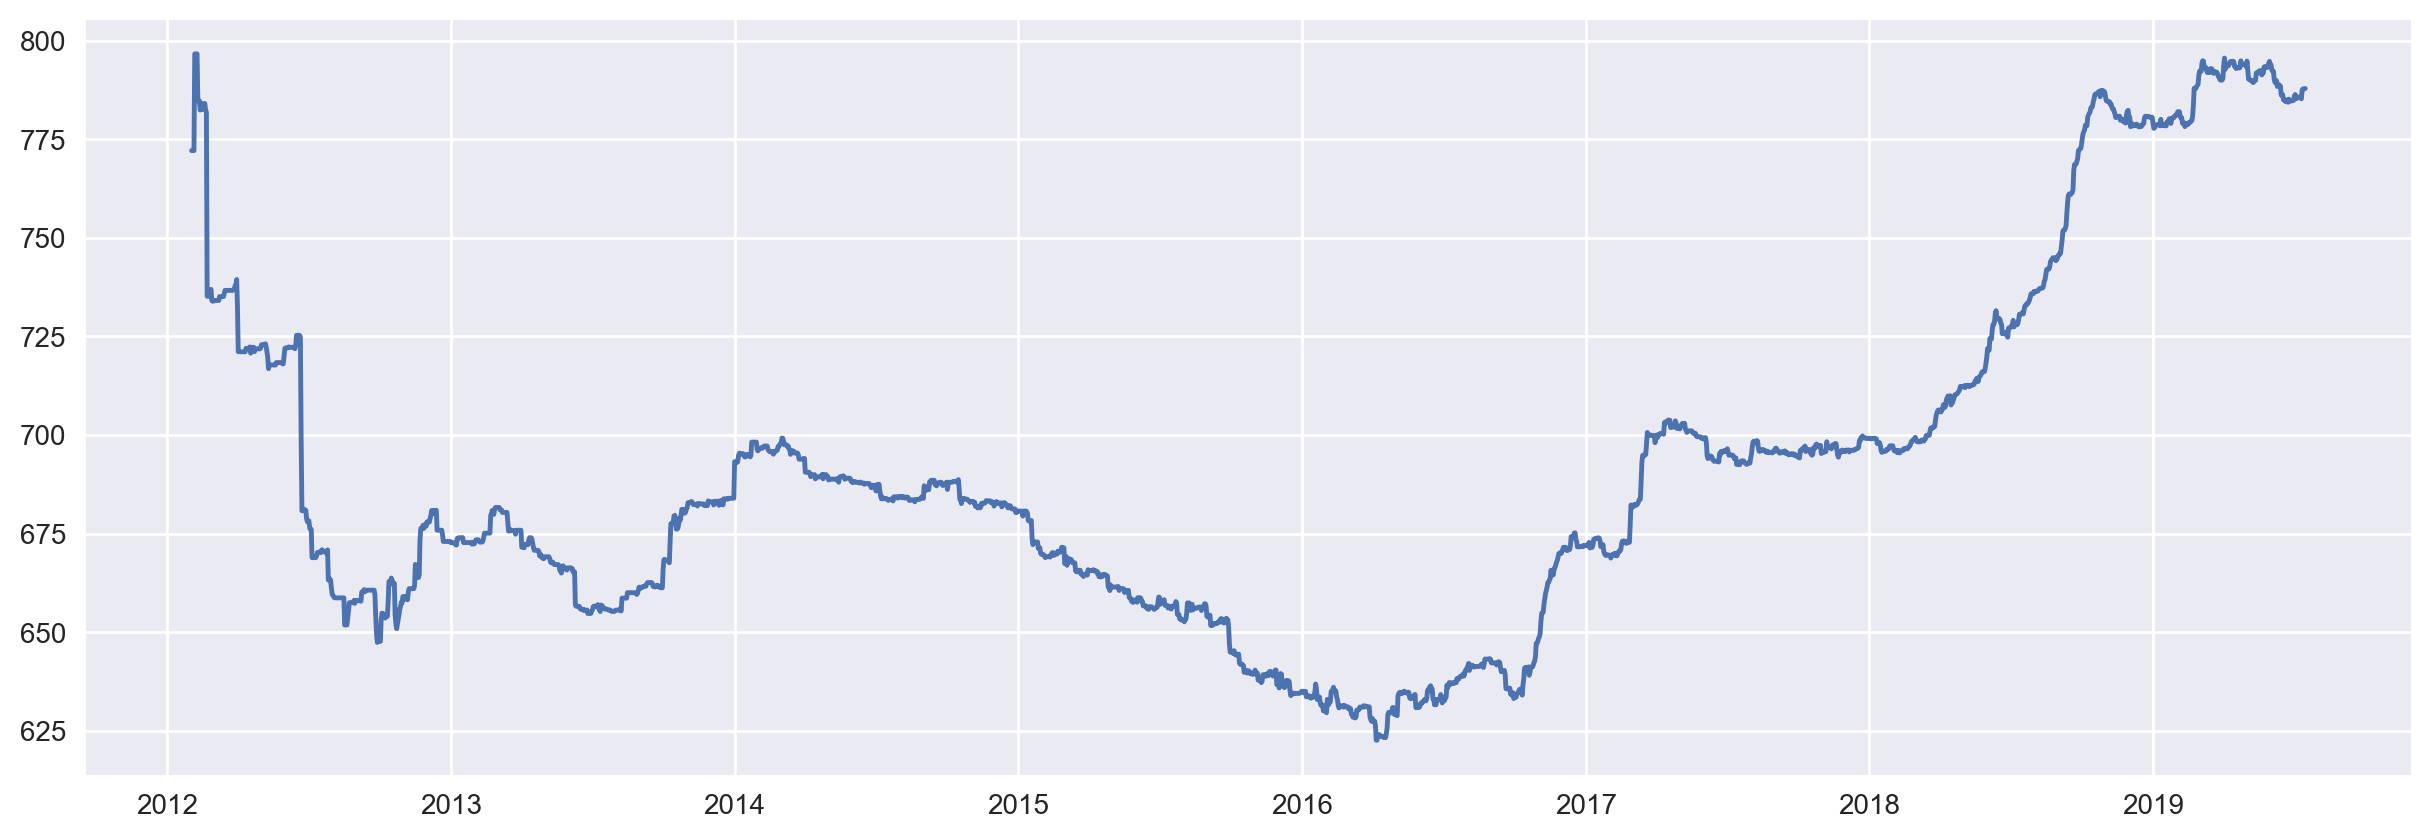

In [4]:
plt.figure(figsize=(15,5),dpi=200)
plt.plot(std_med)

In [5]:
# define a function to create dataset
def create_dataset(dataset, timesteps=36,predict_size=6):
    datax=[]#createx
    datay=[]#createy
    for each in range(len(dataset)-timesteps - predict_steps):
        x = dataset[each:each+timesteps,0]
        y = dataset[each+timesteps:each+timesteps+predict_steps,0]
        datax.append(x)
        datay.append(y)
    return datax, datay

   ## Take 'std' as example to test the performance of the LSTM model

In [6]:
# last 96 days as the validation set, the remaning as the training set
test_std = std_med.values[-96:]
train_std = std_med.values[0:-96]

In [7]:
scaler = MinMaxScaler(feature_range=(0,1))# scale the data in the range between 0 and 1
train_std = scaler.fit_transform(train_std)
train = train_std.copy()
timesteps = 72#create x, that contains 72 data, indicating each time the first 72 data is used as a segment
predict_steps = 12#Create y, which contains 12 data, indicating that the last 12 data is used as a segment
length = 96#predict multiple steps, predict 96 days' cost in total, each time predict 12 days' cost
trainx, trainy = create_dataset(train, timesteps, predict_steps)
trainx = np.array(trainx)
trainy = np.array(trainy)

#shape transform
trainx = np.reshape(trainx,(trainx.shape[0],timesteps,1))#变换shape,以满足keras

In [8]:
#lstm training
model = Sequential()
model.add(LSTM(128,input_shape=(timesteps,1),return_sequences= True))
model.add(Dropout(0.5))
model.add(LSTM(128,return_sequences=True))
#model.add(Dropout(0.3))
model.add(LSTM(64,return_sequences=False))
#model.add(Dropout(0.2))
model.add(Dense(predict_steps))
model.compile(loss="mean_squared_error",optimizer="adam")
model.fit(trainx,trainy, epochs= 50, batch_size=200)

W0809 14:06:06.118515 21492 deprecation_wrapper.py:119] From C:\Users\jillianzhu\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0809 14:06:06.138437 21492 deprecation_wrapper.py:119] From C:\Users\jillianzhu\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0809 14:06:06.142427 21492 deprecation_wrapper.py:119] From C:\Users\jillianzhu\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0809 14:06:06.453626 21492 deprecation_wrapper.py:119] From C:\Users\jillianzhu\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is d

Epoch 1/50
2542/2542 [==============================] - 10s 4ms/step - loss: 0.0723
Epoch 2/50
2542/2542 [==============================] - 8s 3ms/step - loss: 0.0072
Epoch 3/50
2542/2542 [==============================] - 7s 3ms/step - loss: 0.0025
Epoch 4/50
2542/2542 [==============================] - 8s 3ms/step - loss: 0.0016
Epoch 5/50
2542/2542 [==============================] - 9s 3ms/step - loss: 0.0014
Epoch 6/50
2542/2542 [==============================] - 7s 3ms/step - loss: 0.0013
Epoch 7/50
2542/2542 [==============================] - 7s 3ms/step - loss: 0.0013
Epoch 8/50
2542/2542 [==============================] - 7s 3ms/step - loss: 0.0013
Epoch 9/50
2542/2542 [==============================] - 7s 3ms/step - loss: 0.0012
Epoch 10/50
2542/2542 [==============================] - 9s 3ms/step - loss: 0.0012
Epoch 11/50
2542/2542 [==============================] - 12s 5ms/step - loss: 0.0012
Epoch 12/50
2542/2542 [==============================] - 9s 4ms/step - loss: 0.0011

In [9]:
predict_xlist = []#Add predictions in the x list
predict_y = []#add predictions in the y list

predict_xlist.extend(train_std[train_std.shape[0]-timesteps:train_std.shape[0],0].tolist())
while len(predict_y) < length:
    predictx = np.array(predict_xlist[-timesteps:])#Take timesteps data from the latest predict_xlist and predict new predict_steps data
    predictx = np.reshape(predictx,(1,timesteps,1))#Transform the format to fit the LSTM model
    #predict new values
    lstm_predict = model.predict(predictx)
    #rolling predict
    predict_xlist.extend(lstm_predict[0])#Add the newly predicted predict_steps data to the predict_xlist list for the next prediction
    lstm_predict = scaler.inverse_transform(lstm_predict)
    predict_y.extend(lstm_predict[0])

In [10]:
# test the performance of LSTM in the testing set
y_ture = np.array(test_std)
train_score = np.sqrt(mean_squared_error(y_ture,predict_y))
print("train score RMSE: %.2f"% train_score)
y_predict = pd.DataFrame(predict_y,columns=["predict"])

train score RMSE: 9.10


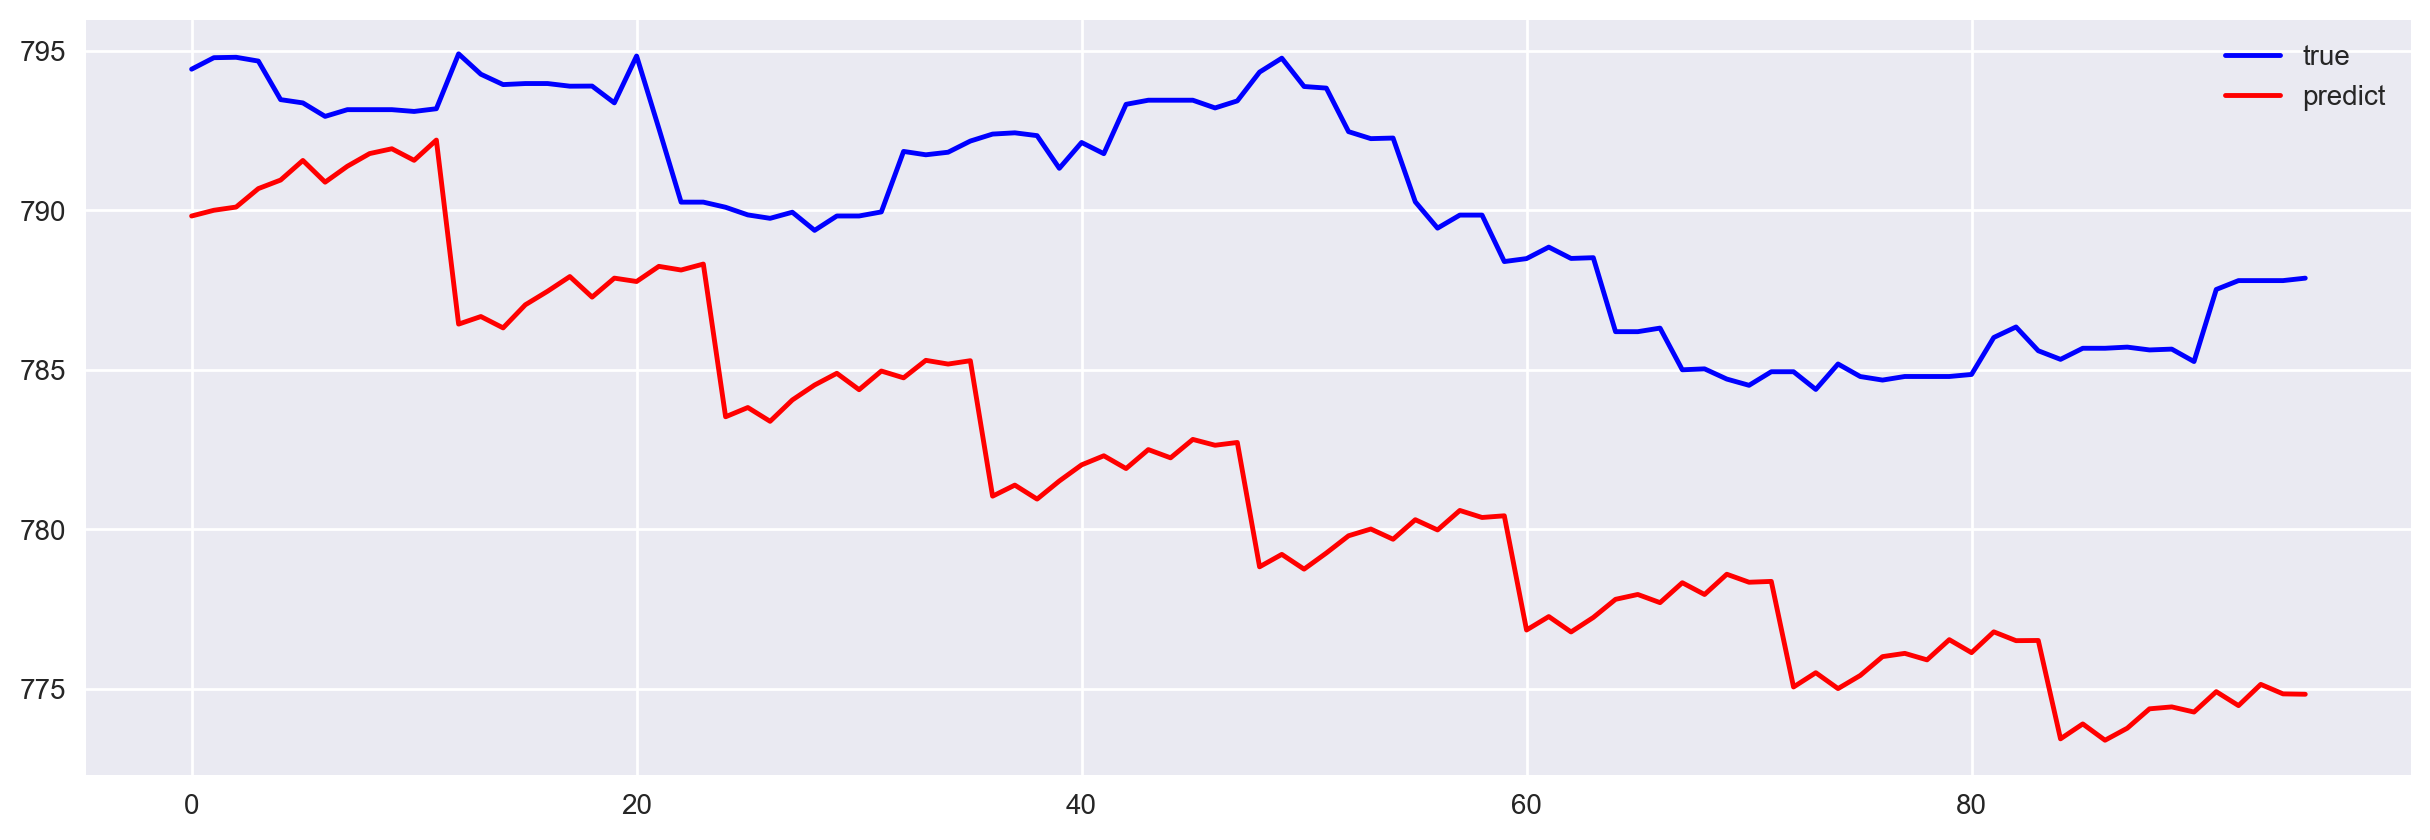

In [18]:
#plot actual data and predicted data
plt.figure(figsize=(15,5),dpi=200)
plt.plot(y_ture,c='b',label='true',scaley=False)
plt.plot(predict_y,c='r',label='predict',scaley=True)
plt.legend()

# Make predictions

* for standard tariffs

In [14]:
#predicting date
pred_index = pd.date_range(start='2019-07-17', periods=96)

In [15]:
stdf = std_med.values
scaler = MinMaxScaler(feature_range=(0,1))
stdf = scaler.fit_transform(stdf)
train = stdf.copy()
timesteps = 72
predict_steps = 12
length = 96#predict next 96 days in total
trainx, trainy = create_dataset(train, timesteps, predict_steps)
trainx = np.array(trainx)
trainy = np.array(trainy)

#shape transform
trainx = np.reshape(trainx,(trainx.shape[0],timesteps,1))

In [16]:
#lstm training
model = Sequential()
model.add(LSTM(128,input_shape=(timesteps,1),return_sequences= True))
model.add(Dropout(0.5))
model.add(LSTM(128,return_sequences=True))
#model.add(Dropout(0.3))
model.add(LSTM(64,return_sequences=False))
#model.add(Dropout(0.2))
model.add(Dense(predict_steps))
model.compile(loss="mean_squared_error",optimizer="adam")
model.fit(trainx,trainy, epochs= 50, batch_size=200)

predict_xlist = []
predict_y = []
predict_xlist.extend(stdf[stdf.shape[0]-timesteps:stdf.shape[0],0].tolist())
while len(predict_y) < length:
    predictx = np.array(predict_xlist[-timesteps:])
    predictx = np.reshape(predictx,(1,timesteps,1))
    #print("predictx"),print(predictx),print(predictx.shape)
    #predict new values
    lstm_predict = model.predict(predictx)
    #rolling predict
    #print("lstm_predict"),print(lstm_predict[0])
    predict_xlist.extend(lstm_predict[0])
    lstm_predict = scaler.inverse_transform(lstm_predict)
    predict_y.extend(lstm_predict[0])
    
predict_std = pd.DataFrame(predict_y,columns=["cost_mean"],index=pred_index)

Epoch 1/50
2638/2638 [==============================] - 14s 5ms/step - loss: 0.0837
Epoch 2/50
2638/2638 [==============================] - 11s 4ms/step - loss: 0.0084
Epoch 3/50
2638/2638 [==============================] - 12s 4ms/step - loss: 0.0022
Epoch 4/50
2638/2638 [==============================] - 11s 4ms/step - loss: 0.0015
Epoch 5/50
2638/2638 [==============================] - 11s 4ms/step - loss: 0.0013
Epoch 6/50
2638/2638 [==============================] - 10s 4ms/step - loss: 0.0014
Epoch 7/50
2638/2638 [==============================] - 11s 4ms/step - loss: 0.0013
Epoch 8/50
2638/2638 [==============================] - 11s 4ms/step - loss: 0.0012
Epoch 9/50
2638/2638 [==============================] - 11s 4ms/step - loss: 0.0012
Epoch 10/50
2638/2638 [==============================] - 11s 4ms/step - loss: 0.0012
Epoch 11/50
2638/2638 [==============================] - 10s 4ms/step - loss: 0.0012
Epoch 12/50
2638/2638 [==============================] - 11s 4ms/step - lo

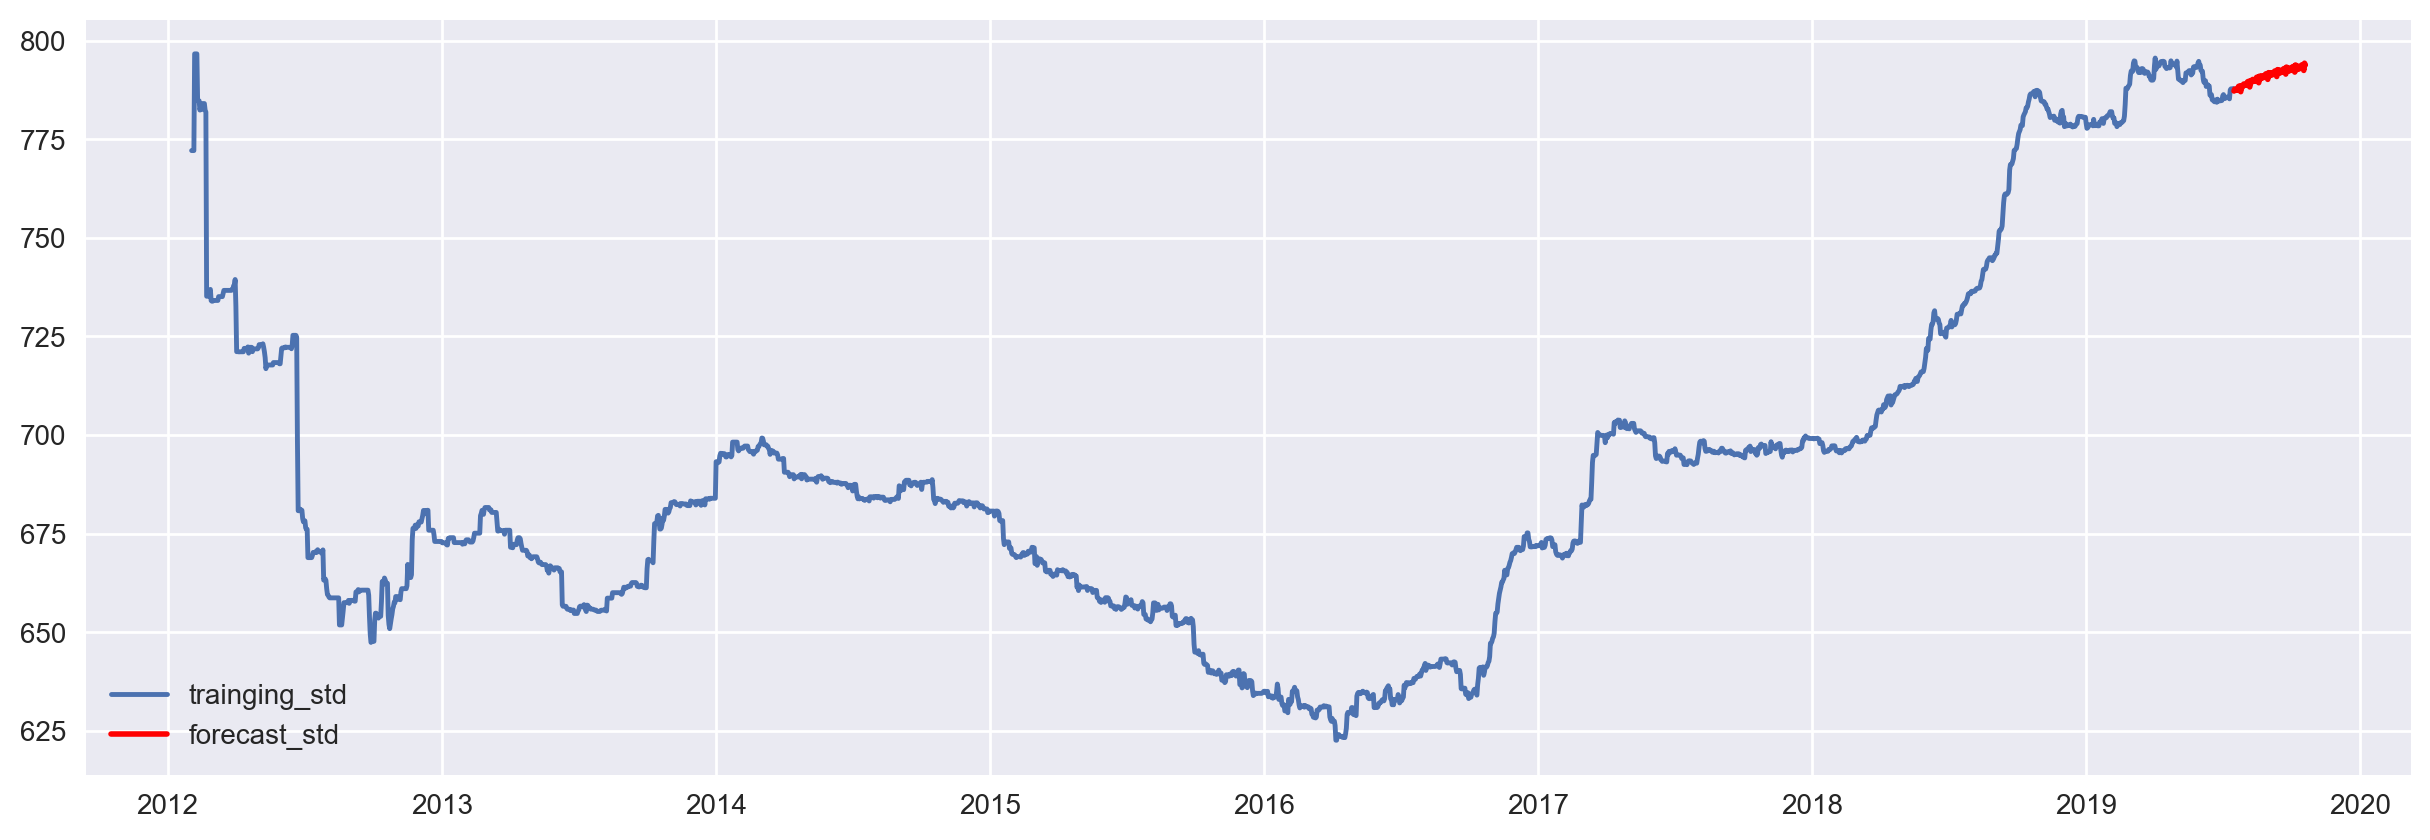

In [37]:
plt.figure(figsize=(15,5),dpi=200)
plt.plot(std_med,label='trainging_std')
plt.plot(predict_std,label='forecast_std',color='r',lw=2)
plt.legend(loc='best')

* for economy 7 tariffs  with 72%/28%

In [48]:
e772f = e7_med72.values

scaler = MinMaxScaler(feature_range=(0,1))
e772f = scaler.fit_transform(e772f)
train = e772f.copy()
timesteps = 72#create x
predict_steps = 12#create y
length = 96#predict 96 days 
trainx, trainy = create_dataset(train, timesteps, predict_steps)
trainx = np.array(trainx)
trainy = np.array(trainy)

#shape transform
trainx = np.reshape(trainx,(trainx.shape[0],timesteps,1))

In [49]:
#lstm training
model = Sequential()
model.add(LSTM(128,input_shape=(timesteps,1),return_sequences= True))
model.add(Dropout(0.5))
model.add(LSTM(128,return_sequences=True))
#model.add(Dropout(0.3))
model.add(LSTM(64,return_sequences=False))
#model.add(Dropout(0.2))
model.add(Dense(predict_steps))
model.compile(loss="mean_squared_error",optimizer="adam")
model.fit(trainx,trainy, epochs= 50, batch_size=200)

predict_xlist = []#add predict x list
predict_y = []#add predict y list
predict_xlist.extend(e772f[e772f.shape[0]-timesteps:e772f.shape[0],0].tolist())
while len(predict_y) < length:
    predictx = np.array(predict_xlist[-timesteps:])
    predictx = np.reshape(predictx,(1,timesteps,1))
    #predicting
    lstm_predict = model.predict(predictx)
    #rolling predict
    predict_xlist.extend(lstm_predict[0])
    lstm_predict = scaler.inverse_transform(lstm_predict)
    predict_y.extend(lstm_predict[0])

predict_e772 = pd.DataFrame(predict_y,columns=["cost_mean"],index=pred_index)

Epoch 1/50
2638/2638 [==============================] - 21s 8ms/step - loss: 0.0828
Epoch 2/50
2638/2638 [==============================] - 14s 5ms/step - loss: 0.0069
Epoch 3/50
2638/2638 [==============================] - 15s 6ms/step - loss: 0.0020
Epoch 4/50
2638/2638 [==============================] - 14s 5ms/step - loss: 0.0014
Epoch 5/50
2638/2638 [==============================] - 15s 6ms/step - loss: 0.0013
Epoch 6/50
2638/2638 [==============================] - 14s 5ms/step - loss: 0.0013
Epoch 7/50
2638/2638 [==============================] - 15s 6ms/step - loss: 0.0013
Epoch 8/50
2638/2638 [==============================] - 16s 6ms/step - loss: 0.0012
Epoch 9/50
2638/2638 [==============================] - 15s 6ms/step - loss: 0.0011
Epoch 10/50
2638/2638 [==============================] - 15s 6ms/step - loss: 0.0012
Epoch 11/50
2638/2638 [==============================] - 16s 6ms/step - loss: 0.0011
Epoch 12/50
2638/2638 [==============================] - 17s 6ms/step - lo

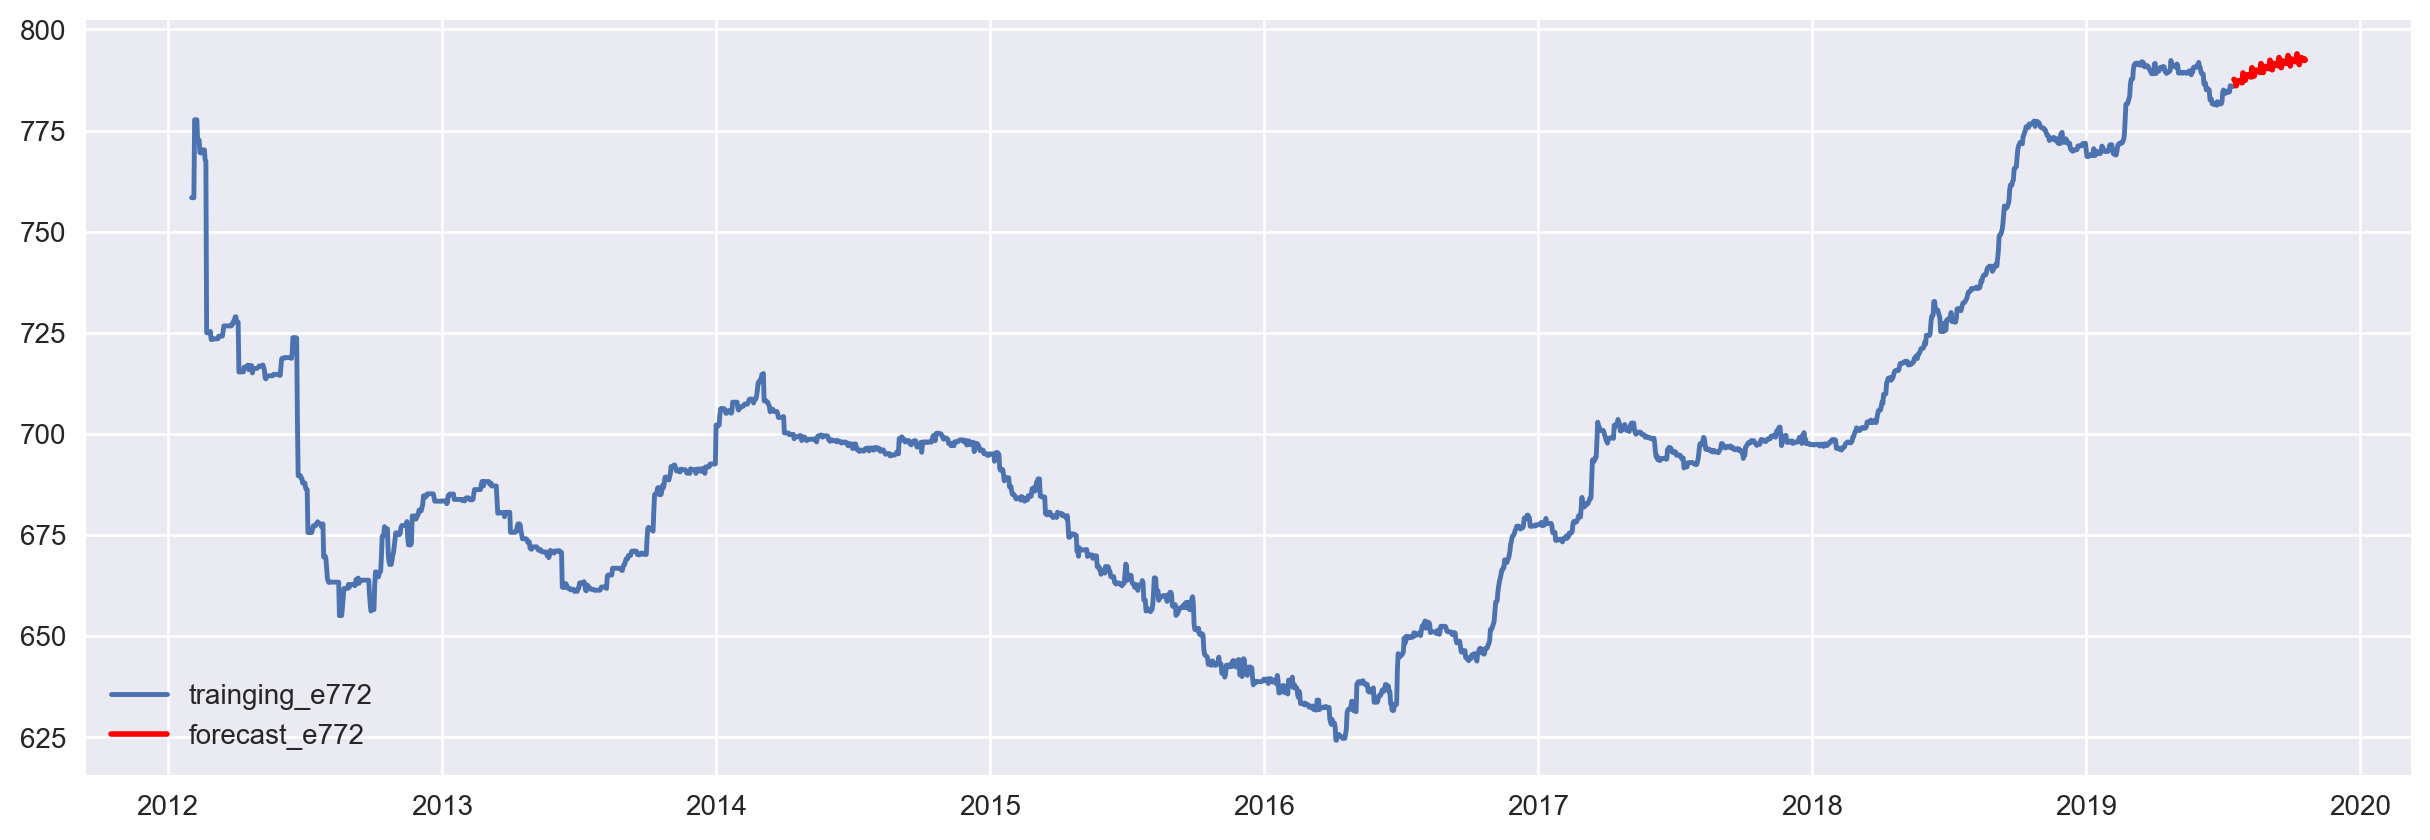

In [38]:
plt.figure(figsize=(15,5),dpi=200)
plt.plot(e7_med72,label='trainging_e772')
plt.plot(predict_e772,label='forecast_e772',color='r',lw=2)
plt.legend(loc='best')

* e7 with 75%/25%

In [28]:
e775f = e7_med75.values

scaler = MinMaxScaler(feature_range=(0,1))
e775f = scaler.fit_transform(e775f)
train = e775f.copy()
timesteps = 72#create x
predict_steps = 12#create y
length = 96#predict 96 days
trainx, trainy = create_dataset(train, timesteps, predict_steps)
trainx = np.array(trainx)
trainy = np.array(trainy)

#shape transform
trainx = np.reshape(trainx,(trainx.shape[0],timesteps,1))

In [29]:
#lstm training
model = Sequential()
model.add(LSTM(128,input_shape=(timesteps,1),return_sequences= True))
model.add(Dropout(0.5))
model.add(LSTM(128,return_sequences=True))
#model.add(Dropout(0.3))
model.add(LSTM(64,return_sequences=False))
#model.add(Dropout(0.2))
model.add(Dense(predict_steps))
model.compile(loss="mean_squared_error",optimizer="adam")
model.fit(trainx,trainy, epochs= 50, batch_size=200)

predict_xlist = []#add x predict list
predict_y = []# add y predict list
predict_xlist.extend(e775f[e775f.shape[0]-timesteps:e775f.shape[0],0].tolist())
while len(predict_y) < length:
    predictx = np.array(predict_xlist[-timesteps:])
    predictx = np.reshape(predictx,(1,timesteps,1))
    
    #predicting
    lstm_predict = model.predict(predictx)
    #rolling predicting
    #print("lstm_predict"),print(lstm_predict[0])
    predict_xlist.extend(lstm_predict[0])#
    lstm_predict = scaler.inverse_transform(lstm_predict)
    predict_y.extend(lstm_predict[0])

Epoch 1/50
2638/2638 [==============================] - 26s 10ms/step - loss: 0.0802
Epoch 2/50
2638/2638 [==============================] - 10s 4ms/step - loss: 0.0071
Epoch 3/50
2638/2638 [==============================] - 16s 6ms/step - loss: 0.0024
Epoch 4/50
2638/2638 [==============================] - 11s 4ms/step - loss: 0.0016
Epoch 5/50
2638/2638 [==============================] - 10s 4ms/step - loss: 0.0014
Epoch 6/50
2638/2638 [==============================] - 14s 5ms/step - loss: 0.0013
Epoch 7/50
2638/2638 [==============================] - 15s 6ms/step - loss: 0.0013
Epoch 8/50
2638/2638 [==============================] - 13s 5ms/step - loss: 0.0013
Epoch 9/50
2638/2638 [==============================] - 15s 6ms/step - loss: 0.0013
Epoch 10/50
2638/2638 [==============================] - 10s 4ms/step - loss: 0.0012
Epoch 11/50
2638/2638 [==============================] - 9s 4ms/step - loss: 0.0012
Epoch 12/50
2638/2638 [==============================] - 9s 4ms/step - los

In [30]:
predict_e775 = pd.DataFrame(predict_y,columns=["cost_mean"],index=pred_index)

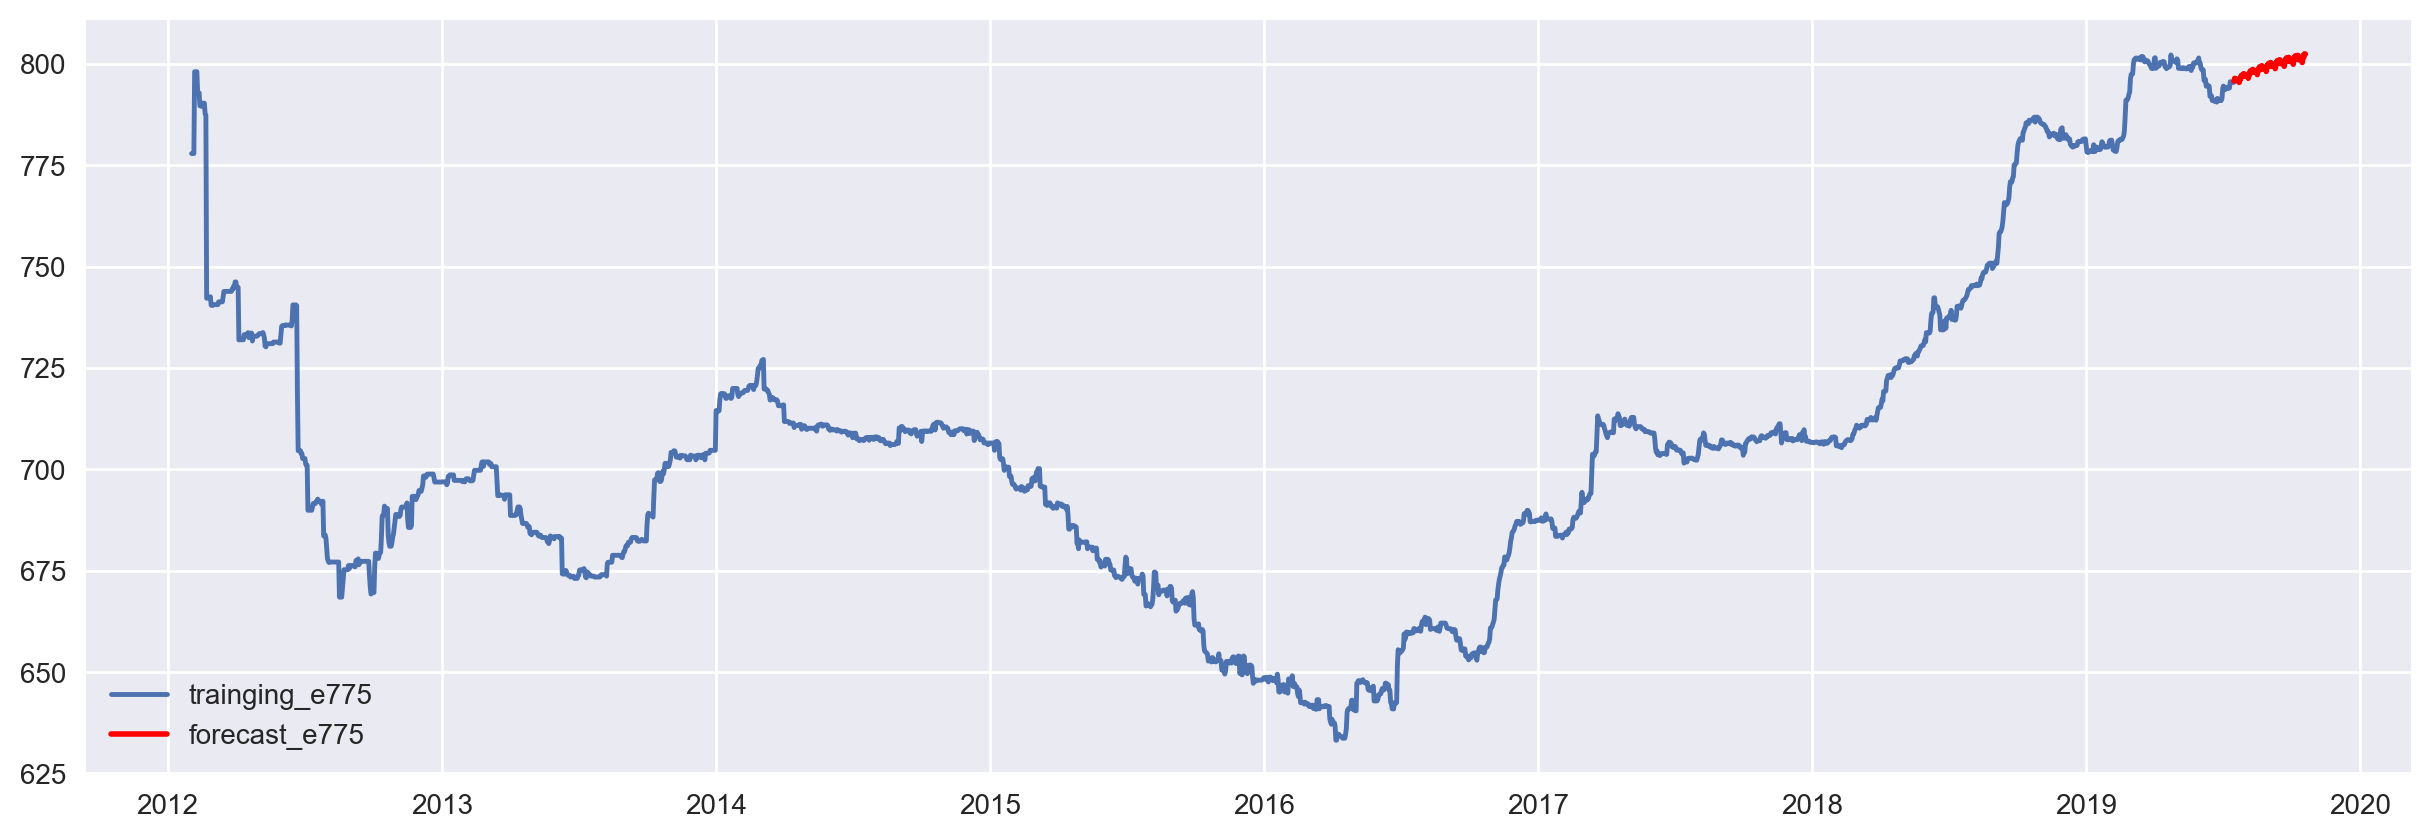

In [40]:
plt.figure(figsize=(15,5),dpi=200)
plt.plot(e7_med75,label='trainging_e775')
plt.plot(predict_e775,label='forecast_e775',color='r',lw=2)
plt.legend(loc='best')

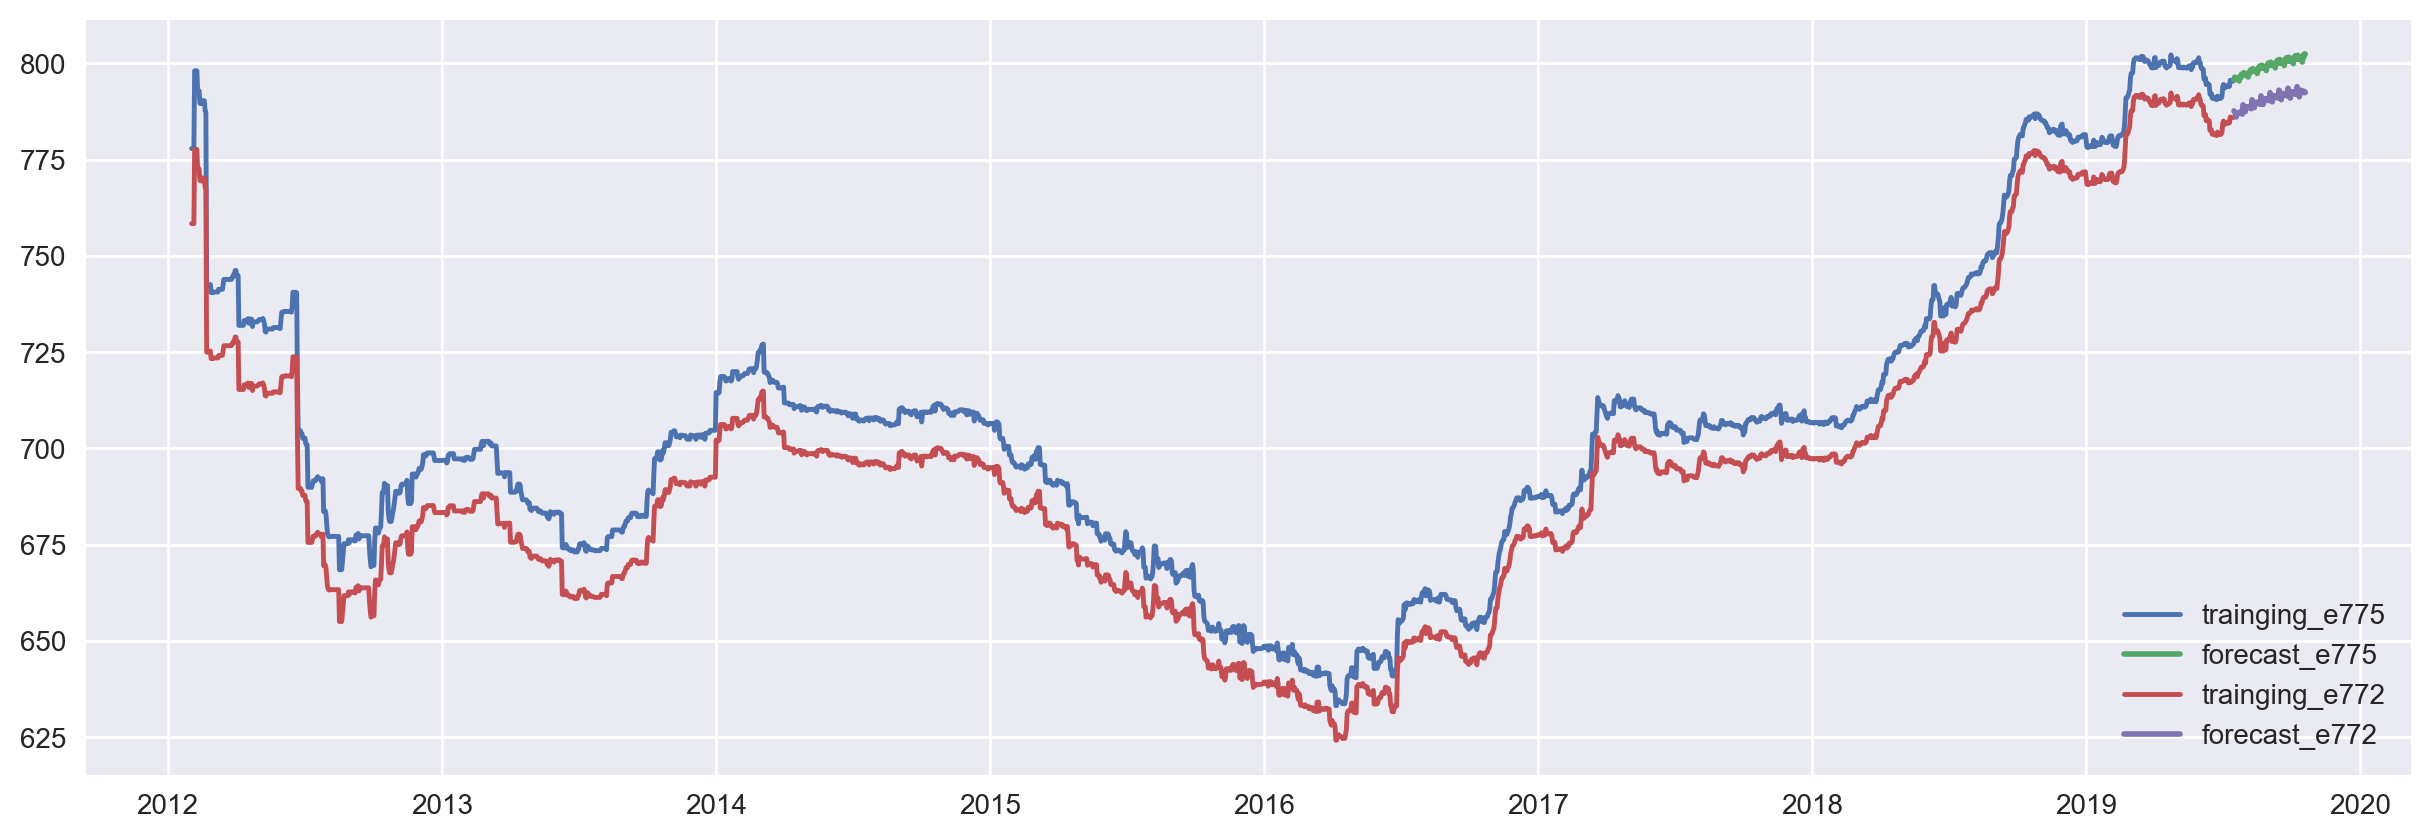

In [42]:
#standard tariffs vs economy 7 tariffs with split of 0.75/0.25
plt.figure(figsize=(15,5),dpi=200)
plt.plot(e7_med75,label='trainging_e775')
plt.plot(predict_e775,label='forecast_e775',lw=2)
plt.plot(e7_med72,label='trainging_e772')
plt.plot(predict_e772,label='forecast_e772',lw=2)
plt.legend(loc='best')

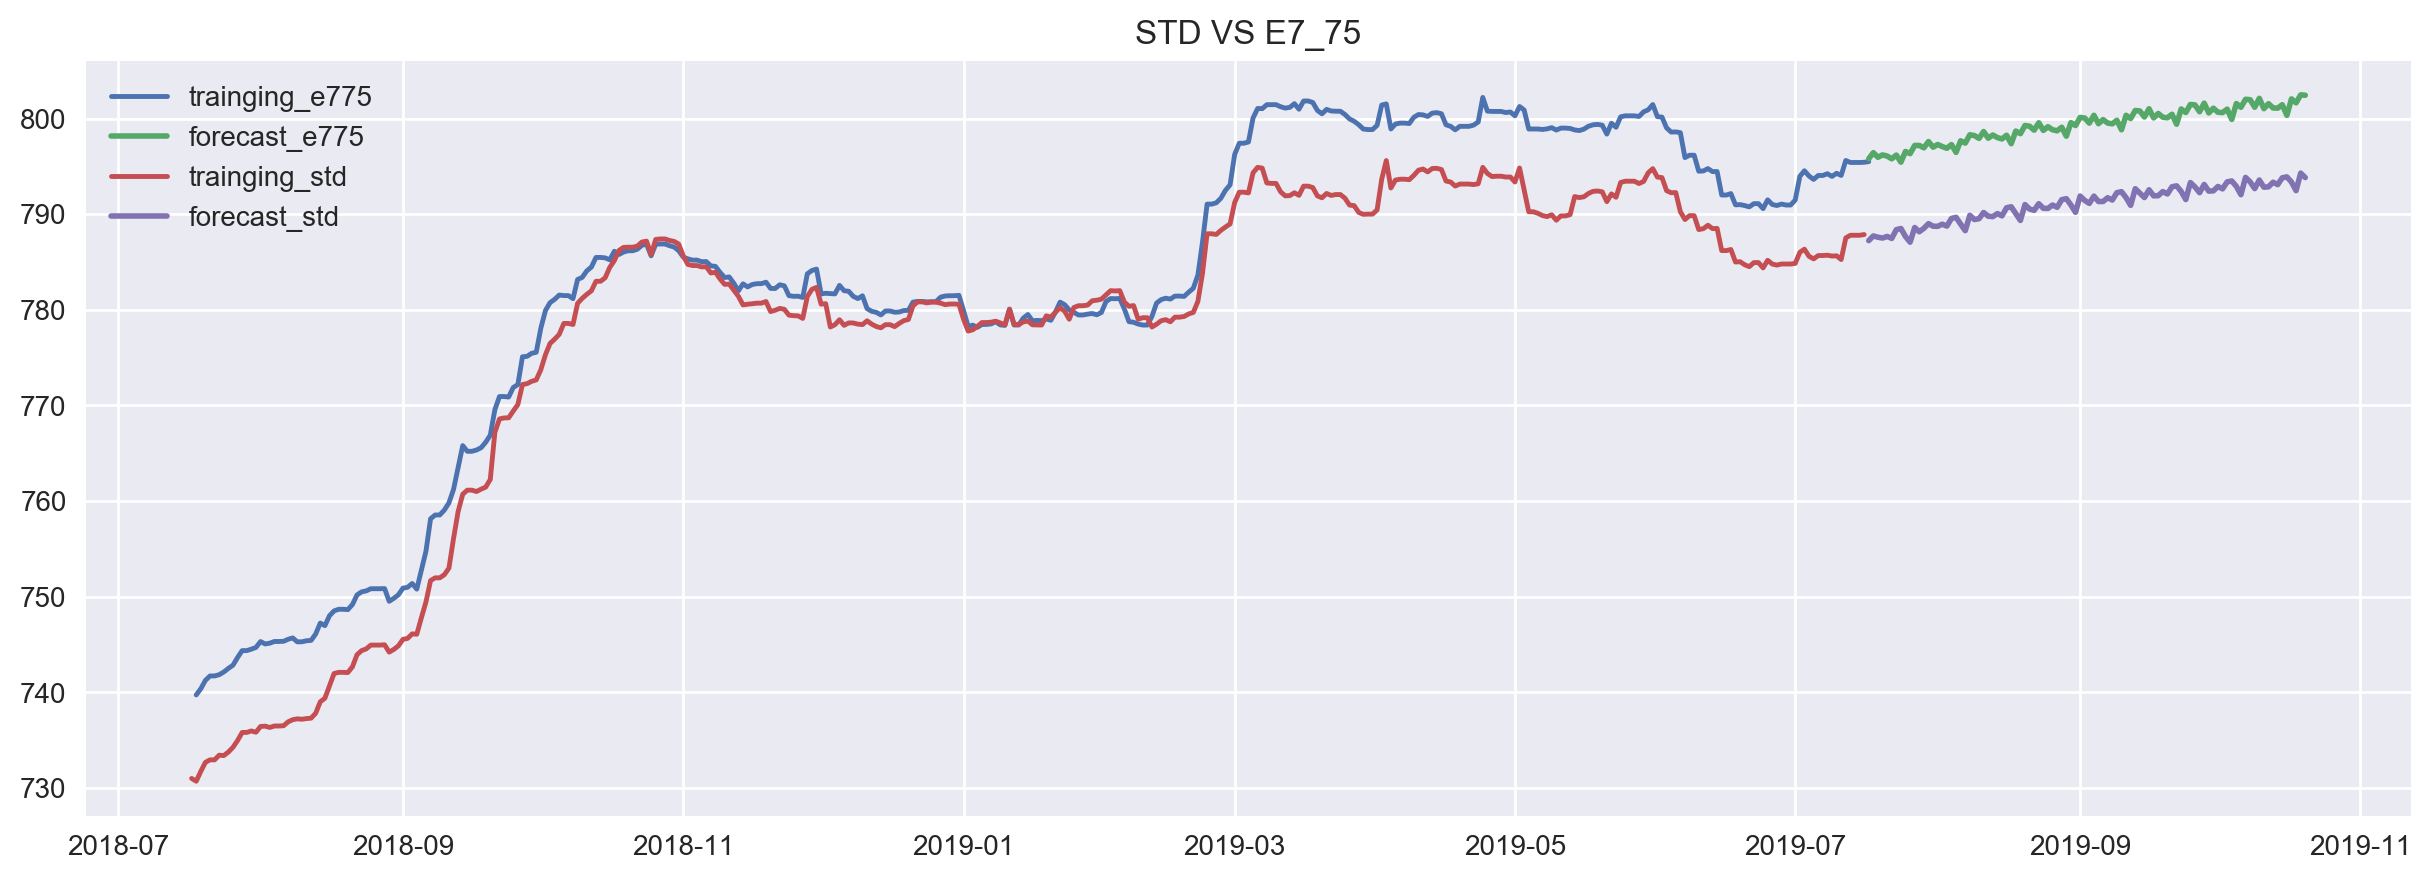

In [29]:
#standard tariffs vs economy 7 tariffs with split of 0.75/0.25
#only plot last 365 days' data
plt.figure(figsize=(15,5),dpi=200)
plt.plot(e7_med75[-365:],label='trainging_e775')
plt.plot(predict_e775,label='forecast_e775',lw=2)
plt.plot(std_med[-365:],label='trainging_std')
plt.plot(predict_std,label='forecast_std',lw=2)
plt.title('STD VS E7_75')
plt.legend(loc='best')
plt.savefig('std_75.png')

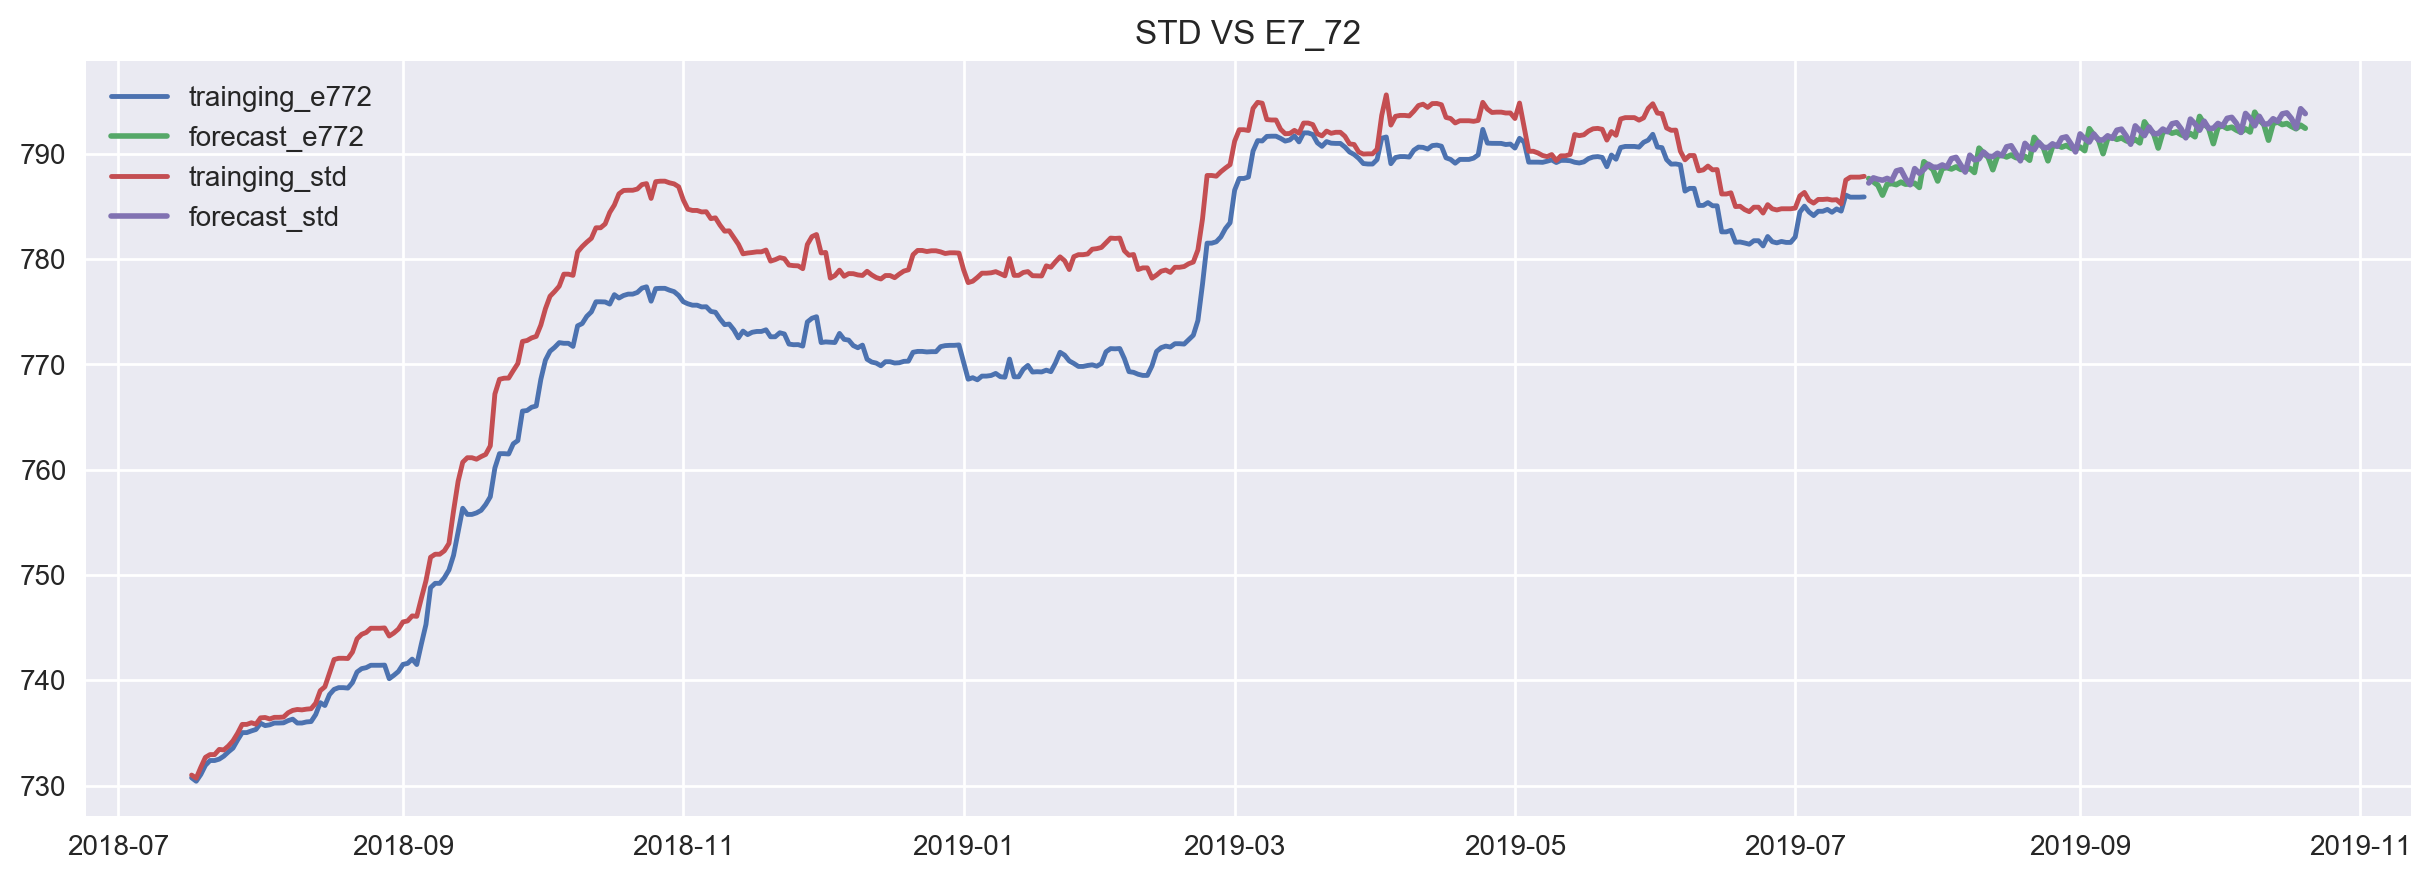

In [9]:
#standard tariffs vs economy 7 tariffs with split of 0.72/0.28
#only plot last 365 days' data
plt.figure(figsize=(15,5),dpi=200)
plt.plot(e7_med72[-365:],label='trainging_e772')
plt.plot(predict_e772,label='forecast_e772',lw=2)
plt.plot(std_med[-365:],label='trainging_std')
plt.plot(predict_std,label='forecast_std',lw=2)
plt.legend(loc='best')
plt.title('STD VS E7_72')
plt.savefig('std_72.png')

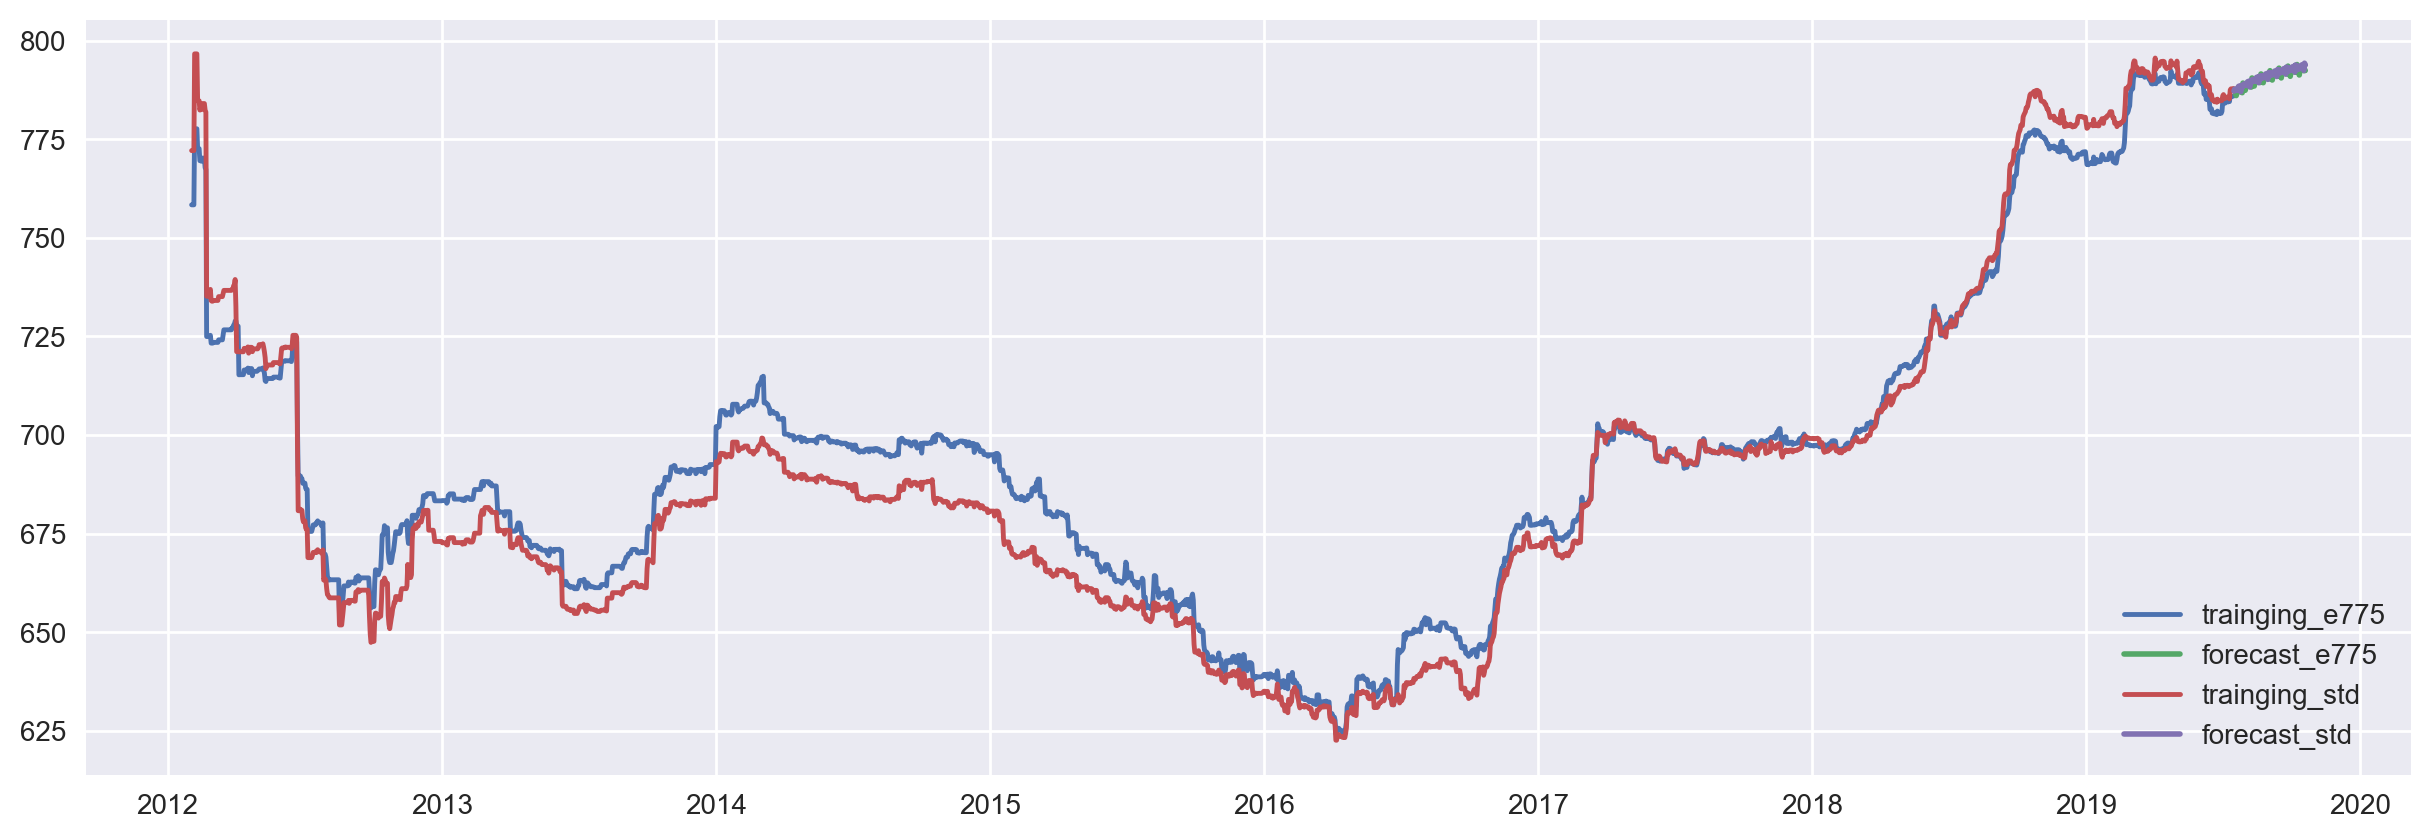

In [27]:
plt.figure(figsize=(15,5),dpi=200)
plt.plot(e7_med72,label='trainging_e775')
plt.plot(predict_e772,label='forecast_e775',lw=2)
plt.plot(std_med,label='trainging_std')
plt.plot(predict_std,label='forecast_std',lw=2)
plt.legend(loc='best')

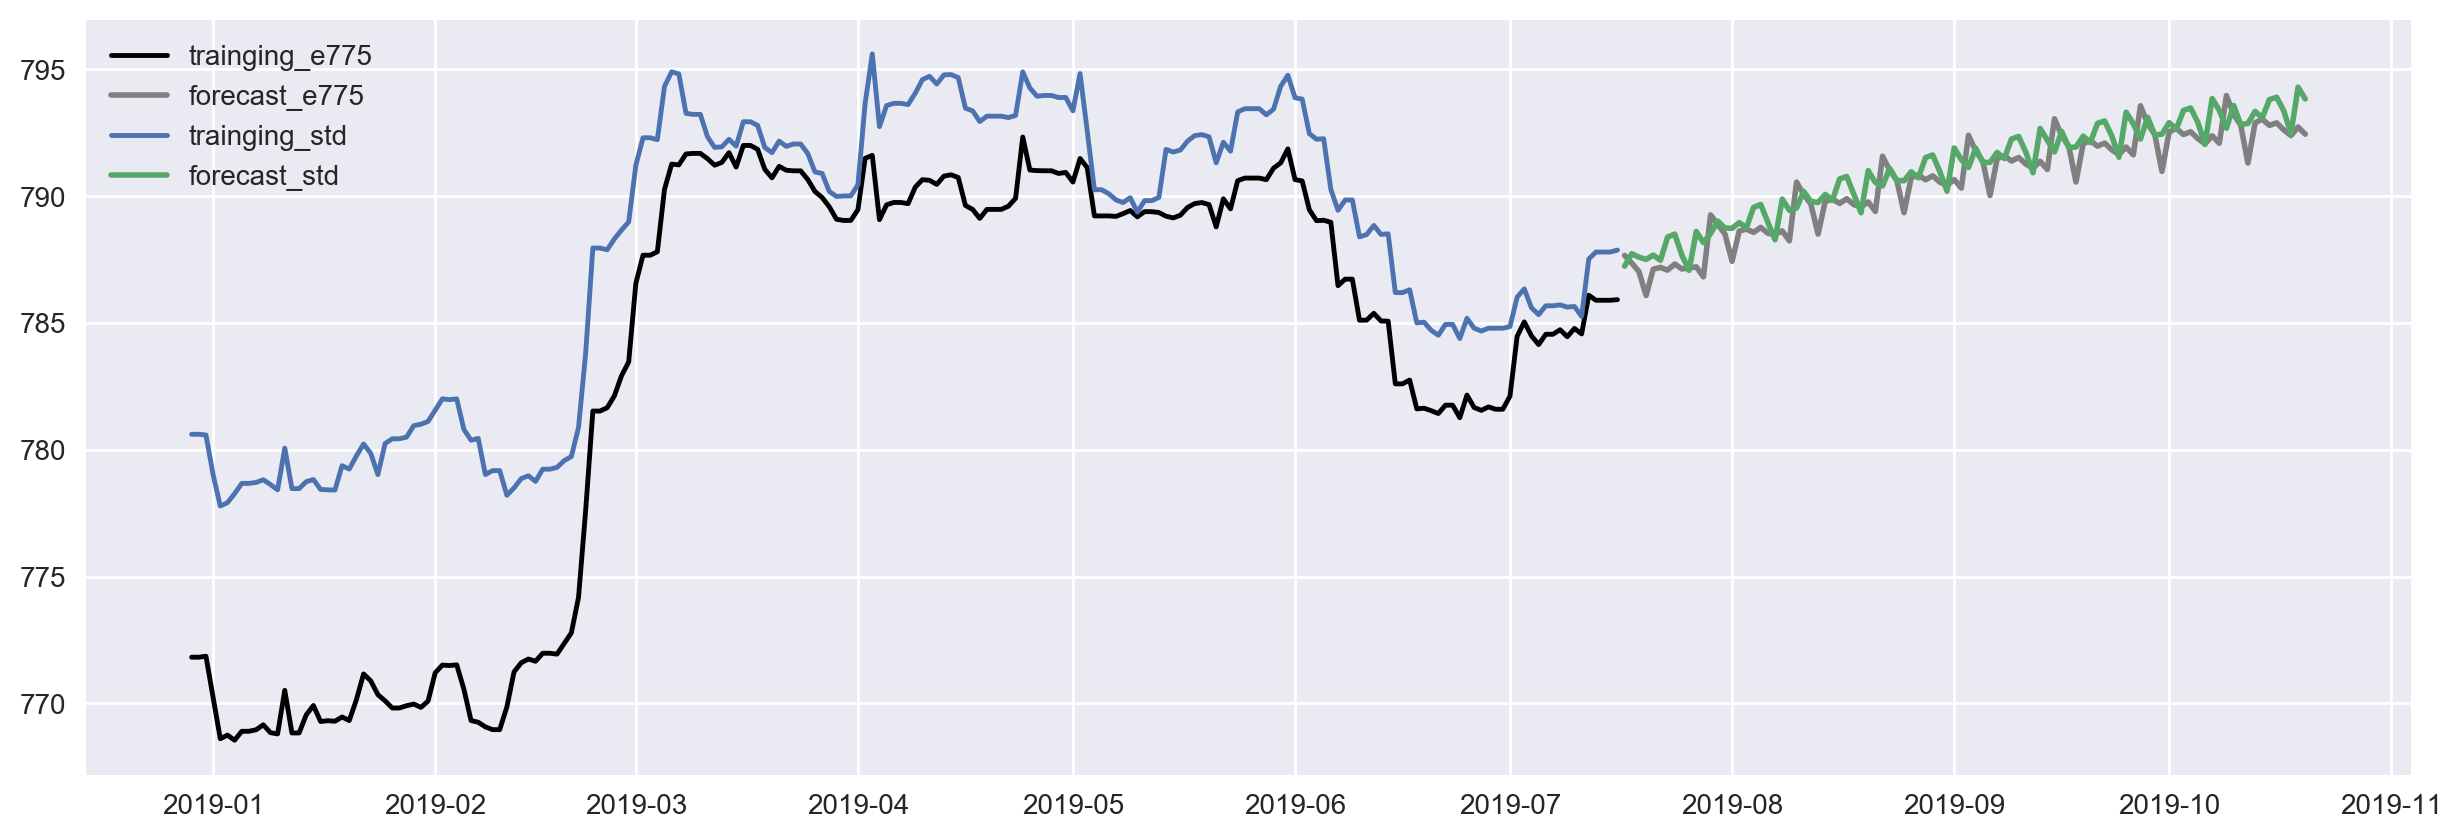

In [46]:
plt.figure(figsize=(15,5),dpi=200)
plt.plot(e7_med72[-200:],label='trainging_e775',color='black')
plt.plot(predict_e772,label='forecast_e775',lw=2,color='grey')
plt.plot(std_med[-200:],label='trainging_std')
plt.plot(predict_std,label='forecast_std',lw=2)
plt.legend(loc='best')